# Подготовка данных пациентов

In [29]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sbs
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
import transformers
from tqdm import notebook
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier

import imblearn
from imblearn.over_sampling import SMOTE

## Загрузка данных

In [2]:
file_path = 'chd_addmit_300.xlsx'

In [3]:
patient_data = pd.read_excel(file_path)

In [4]:
patient_data.head()

,admittion,discharge,sex,height,weight,BMI,BSA,birth,Операции (все в ИБ),Перенесенные опер. (из Анамн.),...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,2016-12-12,2017-01-10,m,76,9.70,111.27,0.46,02.01.2016,12.12.2016: (Откр./ИК) Перевязка ранее наложен...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-13,2017-02-01,f,67,7.34,89.67,0.37,02.02.2016,18.01.2017: (Откр./ИК) Радикальная коррекция д...,15.08.2016г.: Транслюминальная балонная вальву...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-17,2017-02-09,m,74,8.90,103.46,0.43,21.02.2016,19.01.2017: (Откр./ИК) Перевязка ранее наложен...,29.02.2016 - подключично-легочный анастомоз сп...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-20,2017-02-21,f,67,6.97,85.15,0.36,02.03.2016,23.01.2017: (Откр./ИК) Наложение двустороннего...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-13,2017-03-01,m,82,9.29,102.59,0.46,08.03.2016,15.02.2017: (Откр./ИК) Реконструкция путей отт...,13.04.2016. НАЗВАНИЕ ОПЕРАЦИИ: Транслюминальна...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 42 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   admittion                                        300 non-null    datetime64[ns]
 1   discharge                                        300 non-null    datetime64[ns]
 2   sex                                              300 non-null    object        
 3   height                                           300 non-null    int64         
 4   weight                                           300 non-null    float64       
 5   BMI                                              298 non-null    float64       
 6   BSA                                              298 non-null    float64       
 7   birth                                            300 non-null    object        
 8   Операции (все в ИБ)                     

In [6]:
patient_data.describe()

,height,weight,BMI,BSA,target,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
count,300.000000,300.000000,298.000000,298.000000,300.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,64.890000,6.293560,76.834430,0.336477,0.046667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.076012,1.951695,20.640196,0.073846,0.211276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,39.000000,1.270000,20.340000,0.120000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,60.000000,4.868500,62.007500,0.280000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65.500000,6.442500,78.430000,0.350000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,71.000000,7.651250,91.797500,0.390000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,85.000000,12.000000,137.650000,0.520000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Успешно создан датасет. Необходимо изменить тип данных некоторых признаков, убрать пропуски.

## Предобработка

### Main dataset

In [7]:
main_dataset = pd.DataFrame()

In [8]:
main_dataset[['sex','height','weight','BMI','BSA', 'target']] = patient_data[['sex','height','weight','BMI','BSA', 'target']]

### Разделение на тип операций

In [9]:
operation_type_regular_expr = r'\(([a-zA-Zа-яА-ЯёЁ0-9_.-/ ]+)\)'

def get_first_operation_type(text):
    return re.search(operation_type_regular_expr, text).group(1)

get_first_operation_type(patient_data['Операции (все в ИБ)'][0])

'Откр./ИК'

In [10]:
main_dataset['operation_type'] = patient_data['Операции (все в ИБ)'].apply(get_first_operation_type)

### Уберем пропуски

In [11]:
main_dataset.isnull().sum()

sex               0
height            0
weight            0
BMI               2
BSA               2
target            0
operation_type    0
dtype: int64

In [12]:
main_dataset = main_dataset.dropna()

In [13]:
main_dataset.isnull().sum()

sex               0
height            0
weight            0
BMI               0
BSA               0
target            0
operation_type    0
dtype: int64

## Обучение

### Train test split

In [14]:
X, y = main_dataset.drop('target', axis=1), main_dataset['target']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y)

In [16]:
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)

In [17]:
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True), 

In [18]:
X_train.shape

(193, 6)

In [19]:
X_test.shape

(105, 6)

In [20]:
y_test.value_counts()

0    100
1      5
Name: target, dtype: int64

In [21]:
y_train.value_counts()

0    184
1      9
Name: target, dtype: int64

## OHE

In [22]:
ohe = OneHotEncoder(drop='first').fit(X_train[['sex', 'operation_type']])

In [23]:
pd.DataFrame(ohe.transform(X_train[['sex', 'operation_type']]).toarray())

,0,1,2
0,1.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,0.0
4,1.0,1.0,0.0
...,...,...,...
188,1.0,0.0,1.0
189,0.0,1.0,0.0
190,1.0,0.0,1.0
191,0.0,1.0,0.0


In [24]:
X_train[['sex', 'operation_type', 'operation_type_1']] = pd.DataFrame(ohe.transform(X_train[['sex', 'operation_type']]).toarray())

In [25]:
X_train.sample(5)

,sex,height,weight,BMI,BSA,operation_type,operation_type_1
103,1.0,73,5.65,66.13,0.34,0.0,1.0
18,0.0,71,6.08,72.16,0.35,1.0,0.0
176,1.0,72,7.67,90.39,0.39,1.0,0.0
181,0.0,70,8.03,95.98,0.40,0.0,1.0
159,1.0,64,5.60,70.00,0.32,0.0,1.0


In [26]:
X_test[['sex', 'operation_type', 'operation_type_1']] = ohe.transform(X_test[['sex', 'operation_type']]).toarray()

In [27]:
X_test.sample(5)

,sex,height,weight,BMI,BSA,operation_type,operation_type_1
80,1.0,58,4.148,54.47,0.26,1.0,0.0
59,1.0,57,3.740,49.54,0.25,0.0,0.0
15,1.0,78,8.200,92.85,0.42,1.0,0.0
52,1.0,64,7.125,89.06,0.36,1.0,0.0
57,1.0,74,9.700,112.76,0.45,0.0,1.0


In [30]:
oversample = SMOTE()

In [31]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [32]:
y_train.value_counts()

0    184
1    184
Name: target, dtype: int64

### Catboost

In [33]:
model = CatBoostClassifier(verbose=100)

In [34]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.024756
0:	learn: 0.6642483	test: 0.6702126	best: 0.6702126 (0)	total: 150ms	remaining: 2m 29s
100:	learn: 0.1978269	test: 0.2850510	best: 0.2850510 (100)	total: 245ms	remaining: 2.18s
200:	learn: 0.1326734	test: 0.2514035	best: 0.2514035 (200)	total: 337ms	remaining: 1.34s
300:	learn: 0.0924504	test: 0.2460094	best: 0.2445682 (261)	total: 427ms	remaining: 991ms
400:	learn: 0.0688498	test: 0.2457637	best: 0.2445682 (261)	total: 524ms	remaining: 782ms
500:	learn: 0.0517683	test: 0.2443082	best: 0.2432736 (469)	total: 624ms	remaining: 621ms
600:	learn: 0.0408233	test: 0.2516766	best: 0.2432736 (469)	total: 717ms	remaining: 476ms
700:	learn: 0.0337464	test: 0.2581240	best: 0.2432736 (469)	total: 807ms	remaining: 344ms
800:	learn: 0.0280664	test: 0.2675312	best: 0.2432736 (469)	total: 895ms	remaining: 222ms
900:	learn: 0.0236486	test: 0.2742137	best: 0.2432736 (469)	total: 989ms	remaining: 109ms
999:	learn: 0.0207094	test: 0.2792894	best: 0.2432736 (469)	total: 1.09s	

<AxesSubplot:>

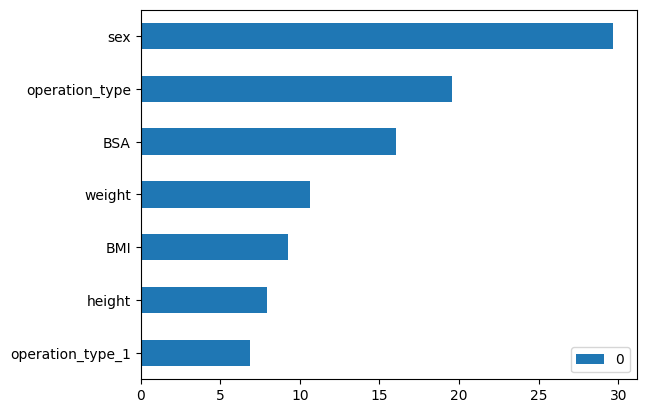

In [52]:
pd.DataFrame(data=model.feature_importances_, index=X_train.columns).sort_values(by=0).plot(kind='barh')

In [75]:
th = 0.4

In [76]:
predictions = model.predict_proba(X_test)[:,1] > th

In [77]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       100
           1       0.14      0.40      0.21         5

    accuracy                           0.86       105
   macro avg       0.55      0.64      0.57       105
weighted avg       0.93      0.86      0.89       105



In [78]:
confusion_matrix(y_test, predictions)

array([[88, 12],
       [ 3,  2]], dtype=int64)